# TODO
- for all figs with Additive false/true fix to plastic, additive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
import os
import time
import re
import random

from sklearn.metrics import precision_recall_curve, auc
from sklearn import preprocessing
from skbio.diversity import alpha_diversity
from skbio.stats.distance import DistanceMatrix
from numpy import zeros
from skbio.stats.ordination import pcoa

import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import georasters as gr

import warnings
warnings.filterwarnings('ignore')

/home/zrimec/miniconda3/envs/plastics/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
# variables

fdata = ['../data/tara_assemblies_parsed.csv',
         '../data/soil_bork_parsed.csv',
         '../data/soil_australia_parsed.csv',
         '../data/soil_china_parsed.csv']

e_cut = 1e-16
col = 'group_id'
corr_f = stats.pearsonr
palett = sns.color_palette("Paired")
legendmap = {False:'polymer',True:'additive'}
legendtit = 'enzyme type'
label_hits = 'Num. plastic degrading enzymes'
label_plast = 'Num. degradable plastic types'

dic = {'tara_assemblies':'ocean', 
       'soil_bork':'soil', 
       'soil_australia':'soil', 
       'soil_china':'soil'}

# plastics as additional
additives = ['PA','phthalate','DBP','TP']
depth_order=['SRF','DCM','MES']
ocean_order=['MS','RS','IO','SO','SAO','NAO','SPO','NPO']
ocean_long={'MS':'Mediterranean_Sea','RS':'Red_Sea',
            'IO':'Ionian_Sea','SO':'Southern_Ocean',
            'SAO':'South_Atlantic_Ocean','NAO':'North_Atlantic_Ocean',
            'SPO':'South_Pacific_Ocean','NPO':'North_Pacific_Ocean'}
df_ocean = pd.DataFrame(ocean_long.keys(),columns=['short'])
df_ocean['long'] = ocean_long.values()
df_ocean.set_index('short').loc[ocean_order].values

col_env = ['18_Depth, reference [m] (Depth ref)',
                 '20_Salinity (Sal)', 
                 '21_Temperature, water, potential [°C] (Tpot)',
                 '23_Oxygen [µmol/kg] (OXYGEN)',
                 '24_Oxygen [µmol/kg] (OXYGEN)', 
                 '25_Nitrate [µmol/l] ([NO3]-)',
                 '26_Nitrite [µmol/l] ([NO2]-)', 
                 '27_Phosphate [µmol/l] ([PO4]3-)',
                 '28_Nitrate and Nitrite [µmol/l] ([NO3]- + [NO2]-)',
                 '29_Silicate [µmol/l] (Si(OH)4)']

In [3]:
# functions

def richness(x):
    return x.nunique()

def shannon(x):
    return alpha_diversity(metric='shannon',
                           counts=x.value_counts().values)

def simpson(x):
    return alpha_diversity(metric='simpson',
                        counts=x.value_counts().values)

def inv_simpson(x,epsilon=1e-6):
    return 1/(epsilon+alpha_diversity(metric='simpson',
                             counts=x.value_counts().values))
    
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = corr_f(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.3f}, p = {p:.1e}', xy=(.1, .9), xycoords=ax.transAxes)
    
def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

# merge on closest value
# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

#http://readiab.org/book/latest/3/1
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    return numerator / denominator

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

def normalize(xx):
    mn = min(xx)
    mx = max(xx)
    return np.array([(x-mn)/(mx-mn) for x in xx])

# Load merge data

### Ocean

In [4]:
# Tara metadata

tara_metadata = (pd
                 .read_excel('../data/Sunagawa_TableS1.xlsx',sheet_name='tableS1')
                 .rename(columns={'INSDC sample accession number(s)':'inscd_id',
                                  'INSDC run accession number(s)':'run',
                                  'Latitude [degrees North]':'latitude',
                                  'Longitude [degrees East]':'longitude'})
                )
tara_metadata['sample_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[:2]))
                             )
tara_metadata['depth_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['depth_id2'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['size_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[3:]))
                             )

# rename MIX as DCM 
tara_metadata.loc[tara_metadata.depth_id=='MIX','depth_id'] = 'DCM'

print(tara_metadata.sample_id.unique().shape)
print(tara_metadata.shape)
tara_metadata.head()

# location grouping variables
marine_groups = ['Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]',
    'Marine provinces  (Longhurst 2007)',
    'Biogeographic biomes (Longhurst 2007)']

# define ocean, ocean province, biome
tara_metadata['ocean'] = tara_metadata[marine_groups[0]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['ocean_province'] = tara_metadata[marine_groups[1]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['biome'] = tara_metadata[marine_groups[2]]

# replace id with the one we are using
to_replace = {'ERS492821|ERS492814':'ERS492814'}
tara_metadata = tara_metadata.replace({'inscd_id':to_replace})

tara_sample_map = pd.read_csv('../data/tara-assembly-sample-mapping.txt'
                              ,sep='\t',names=['sample_id','inscd_id','samea_id'])

tara_sample_map['sample_id_short'] = (tara_sample_map
                                      .sample_id
                                      .apply(lambda x: x[:6])
                                     )
tara_sample_map

# load more env data
f_tmp = '../data/output_pangea_sample_identifiers.tab'
cols = (pd.read_csv('../data/tara_env_column_names.tab',sep='*',
           usecols=[0],header=None)[0]
        .str.strip(' ') # drop trailing whitespace
        .reset_index()
       )
cols = (cols['index'].apply(str)+'_'+cols[0])

df_env = (pd
          .read_csv(f_tmp,sep='\t',names=cols)
          .merge(tara_metadata[['inscd_id','PANGAEA sample identifier']],
                left_on='0_Sample ID (Sample ID)',
                 right_on='PANGAEA sample identifier',how='left')
          )
print(df_env.shape)
df_env.head()

(69,)
(243, 21)
(243, 65)


,0_Sample ID (Sample ID),1_Basis of event (Basis),2_Campaign of event (Campaign),3_Station label (Station),4_Event label (Event),5_Optional event label (Event 2),6_Method/Device of event (Method/Device),7_Date/Time of event (Date/Time),8_Latitude of event (Latitude),9_Longitude of event (Longitude),...,"55_Moon phase, proportion (Moon phase proportion)",56_Sunshine duration [min] (SSD),"57_Geostrophic velocity, longitudinal [cm/s] (u)","58_Geostrophic velocity, latitudinal [cm/s] (v)",59_Okubo-Weiss parameter (OW),60_Maximum Lyapunov exponent [1/day] (MLE),"61_Sea surface temperature gradient, horizontal [°C/100 km] (SST grad h)",62_Residence time [days] (RT),inscd_id,PANGAEA sample identifier
0,TARA_X000000368,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1800Z_004_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-15T18:00,36.5533,-6.5669,...,0.15,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487936,TARA_X000000368
1,TARA_Y200000002,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1130Z_004_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-15T11:30,36.5533,-6.5669,...,0.15,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487899,TARA_Y200000002
2,TARA_A200000159,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1608Z_007_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-23T16:08,37.0541,1.9478,...,0.25,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477953,TARA_A200000159
3,TARA_A200000113,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1250Z_007_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-23T12:50,37.0510,1.9378,...,0.25,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477931,TARA_A200000113
4,TARA_X000001036,SV Tara,TARA_20090926Z,TARA_009,TARA_20090928T1659Z_009_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-28T16:59,39.0609,5.9422,...,0.71,714.0,-16.066,8.651,-0.774,0.083,24.398,24.74,ERS488147,TARA_X000001036


In [5]:
# load
dfs = pd.read_csv(fdata[0])

# mark additives
dfs['additive'] = False
dfs.loc[dfs.plastic.isin(additives),'additive'] = True

# merge on metadata
dfs['sample_id'] = (dfs.target_name
             .apply(lambda x: x.split('|')[1][:6])
            )
dfs = (dfs
        .merge(tara_sample_map.drop(columns='sample_id'),
                        left_on='sample_id',
                        right_on='sample_id_short',
                        how='left')
      .drop(columns=['sample_id_short'])
      .merge(tara_metadata[['inscd_id','run','depth_id',
                            'size_id','ocean','latitude','longitude']],
             on='inscd_id',how='left')
     )

# prokaryote enriched fraction
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
       .inscd_id)

dfs = dfs[dfs.inscd_id.isin(tmp)]
print(dfs.inscd_id.unique().shape)
print(dfs.shape)

# cleanup
dfs.drop(columns=['target_id','samea_id','label']
        ,inplace=True)
dfs['group_id'] = dfs.run
print(dfs.shape)

dfa = []
dfa.append(dfs)

(139,)
(12484, 32)
(12484, 30)


### Soil

In [6]:
# soil metadata
df_soil_env = pd.read_csv('../data/df_soil_env.csv')

# use ena cross-mapping file
ena = pd.read_csv('../data/filereport_read_run_PRJEB18701_tsv.txt',sep='\t')
ena['filename'] = ena.submitted_ftp.apply(lambda x: x.split('/')[-1].split('.')[0])
print(ena.filename.unique().shape)
print(ena.sample_alias.unique().shape)

# fix filenames - remove 'R2_' and '_2 from Nrs and '_001' if 'old_' 
ena['filename'] = [x[:-2] if 'Nr' in x else x.replace('R2_','')[:-4] if 'old_' in x else x.replace('R2_','') for x in ena.filename]

(288,)
(189,)


In [7]:
tmp = []
for f in fdata[1:]:
    tmp.append(pd.read_csv(f))
dfs = pd.concat(tmp)
print(dfs.shape)

# sanity check merging on filenames
print(dfs[dfs.dataset=='soil_bork']
                                               .target_name
                                               .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x 
                                                      else '_'.join(x.split('_')[:5]))
                                              .unique()
      .shape
     )
print(all(pd.Series(dfs[dfs.dataset=='soil_bork']
                                               .target_name
                                               .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x 
                                                      else '_'.join(x.split('_')[:5]))
                                              .unique().tolist()
         ).isin(ena.filename.unique().tolist())
))

dfs.at[dfs.dataset=='soil_bork','filename'] = (dfs[dfs.dataset=='soil_bork']
                                               .target_name
                                               .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x 
                                                      else '_'.join(x.split('_')[:5]))
                                              )

# store
dfs['id_other'] = dfs.id
dfs.drop(columns=['id'],inplace=True)

# merge bork data
dfs = (dfs.merge(ena[['filename','run_accession']]
                 .rename(columns={'run_accession':'run'}),
                on='filename',how='left')
      )
print(dfs.shape)

# other datasets
dfs.at[dfs.dataset=='soil_australia','run'] = (dfs[dfs.dataset=='soil_australia']
                                               .target_name
                                               .apply(lambda x: x.split('_')[0])
                                              )
dfs.at[dfs.dataset=='soil_china','run'] = (dfs[dfs.dataset=='soil_china']
                                               .target_name
                                               .apply(lambda x: x.split('_')[0])
                                              )

# merge
dfs = dfs.merge(df_soil_env.drop(columns=['id','dataset']),
                on='run',how='left')

# mark additives
dfs['additive'] = False
dfs.loc[dfs.plastic.isin(additives),'additive'] = True
dfs['ocean'] = 'Soil'

# cleanup
dfs = (dfs
       .drop(columns=['target_id','label',
                  'ph','pevapotrans','npp','moisture','date','carbon',#'nr_tmp'
                  'filename'])
      .rename(columns={'lats':'latitude',
                       'lons':'longitude'})
      )
dfs['group_id'] = dfs.run
print(dfs.shape)

dfa.append(dfs)

(18279, 22)
(262,)
True
(18279, 24)
(18279, 33)


In [8]:
dfa = pd.concat(dfa)
dfa = dfa.rename(columns={'e-value':'e_value'})

# fixes
# rename some countries
dic2 = {'Viet Nam':'Vietnam',
 'Democratic Republic of the Congo':'Democratic Republic of Congo',
 'USA':'United States'}
dfa = dfa.replace({'country':dic2})
dfa.country.unique()

# subset
dfs = dfa.query('e_value<=@e_cut')
print(dfs.shape)

# export supplementary dataset
(dfs[['target_name','hmm_model','plastic','dataset',
      'e_value','score','seqid','auc',
      'latitude','longitude','country',
      'ocean','environment',]]
 .replace({'dataset':{'tara_assemblies':'ocean',
                    'soil_bork':'soil_global'}})
 .replace({'ocean':{'Soil':np.nan}})
).to_csv('../data/Dataset_hits.csv')

(30025, 37)


# Analysis

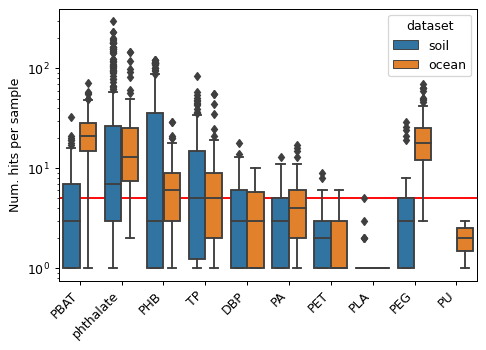

In [9]:
# Plastic hits per sample across datasets

mpl.rcParams['figure.dpi'] = 90
col = 'run'
data = (dfs
      .groupby([col,'plastic'])
      .target_name
      .count()
      .rename('num_hits')
      .reset_index()
     .merge(dfs[[col,'dataset']].drop_duplicates(),
           on=col,how='left')
        .replace({'dataset':dic})
     )
data

sns.boxplot(data=data,
            x='plastic',
            y='num_hits',
           hue='dataset')
plt.yscale('log')
plt.ylabel('Num. hits per sample')
plt.xlabel('')
plt.xticks(rotation=45,ha='right')
plt.plot([-1,20],[data.num_hits.median(),data.num_hits.median()],'r',zorder=0)
plt.xlim([-0.5,9.5])
plt.show()

In [10]:
# averages text

print(dfs.shape)

(data
 .groupby(['dataset','plastic'])
 .num_hits.median()
 .loc['ocean']
 .divide(data
         .groupby(['dataset','plastic'])
         .num_hits
         .median()
         .loc['soil'])
)

(30025, 37)


plastic
DBP          1.000000
PA           1.333333
PBAT         7.000000
PEG          6.000000
PET          0.500000
PHB          2.000000
PLA          1.000000
PU                NaN
TP           1.000000
phthalate    1.857143
Name: num_hits, dtype: float64

In [11]:
# text pla pu smaller amount than others

print((data
 .query('dataset=="ocean"')
 .groupby(['dataset','plastic'])
 .num_hits.median()
 .reset_index(level=0)
 .drop(['PLA','PU'])
 .mean()
)/(data
 .query('dataset=="ocean"')
 .groupby(['dataset','plastic'])
 .num_hits.median()
 .reset_index(level=0)
 .loc[['PLA','PU']]
 .mean()
))

num_hits    5.916667
dtype: float64


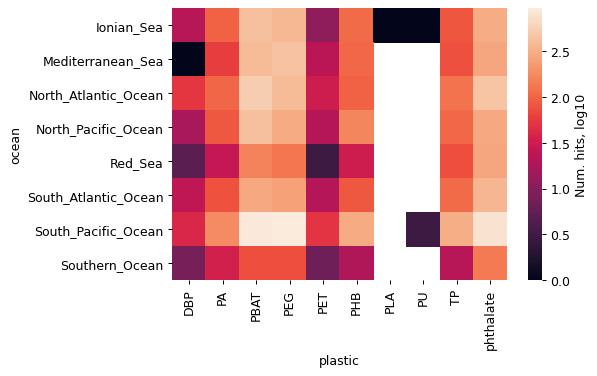

In [12]:
sns.heatmap(data
 .query('dataset=="ocean"')
 .merge(dfs[[col,'ocean']].drop_duplicates(),on=col,how='left')
 .replace({'ocean':ocean_long})
 .groupby(['ocean','plastic'])
 .num_hits.sum().apply(np.log10)
 .unstack(),
    cbar_kws={'label': "Num. hits, log10"}
)
plt.show()

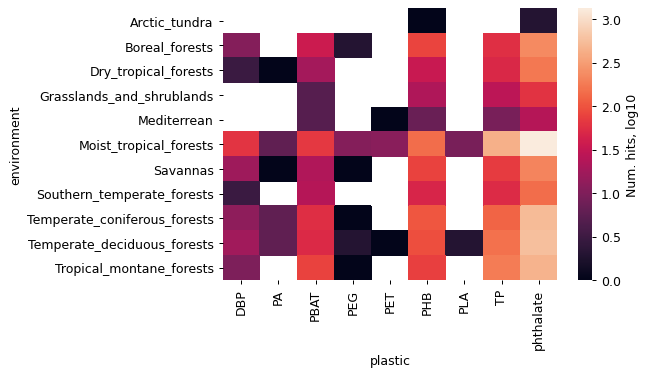

In [13]:
sns.heatmap(data
 .query('dataset=="soil"')
 .merge(dfs[[col,'environment']].drop_duplicates(),on=col,how='left')
 .groupby(['environment','plastic'])
 .num_hits.sum().apply(np.log10)
 .unstack(),
    cbar_kws={'label': "Num. hits, log10"}
)
plt.show()

In [14]:
print(dfs.query('additive==False').plastic.sort_values().unique())
print(dfs.query('additive==True').plastic.sort_values().unique())

['PBAT' 'PEG' 'PET' 'PHB' 'PLA' 'PU']
['DBP' 'PA' 'TP' 'phthalate']


In [15]:
# num sample runs
print(dfs.run.unique().shape)
print(dframe_stack_list(dfs
 .run.dropna()
 .apply(lambda x: x.split('|') if '|' in x else [x])
 .reset_index(),'run',typ='str').run.unique().shape)

(452,)
(566,)


In [16]:
dfs.query('plastic=="PET"').groupby('dataset').target_name.count()

dataset
soil_australia      83
soil_bork           14
soil_china           3
tara_assemblies    171
Name: target_name, dtype: int64

## Num hits/genes

In [17]:
data = '../data/'

cnts = []
for f in [f for f in os.listdir(data) if 'cnt' in f]:
    print(f)
    cnts.append(pd.read_csv(data+f,names=['num_genes']))
    if 'cdhit' in f:
        cnts[-1]['dataset'] = '_'.join(f.split('_')[2:])
        cnts[-1]['type'] = 'cdhit_filtered'
    else:        
        cnts[-1]['dataset'] = '_'.join(f.split('_')[1:])
        cnts[-1]['type'] = 'contigs'
        if cnts[-1]['dataset'][0]=='tara':
            cnts[-1]['dataset']='tara_mags'

cnts = (pd
        .concat(cnts)
        .query('type=="cdhit_filtered"')
        .drop(columns=['type'])
       )
print(cnts.shape)
print(cnts.groupby(['dataset']).sum().sum())
cnts.groupby(['dataset']).sum() 

cnt_soil_china
cnt_tara_assemblies
cnt_cdhit_soil_china
cnt_cdhit_tara_mags
cnt_soil_bork
cnt_cdhit_soil_bork
cnt_cdhit_gut_assemblies
cnt_gut_assemblies
cnt_cdhit_tara_assemblies
cnt_soil_australia
cnt_cdhit_soil_australia
cnt_tara
(6, 2)
num_genes    271088678
dtype: int64


,num_genes
dataset,
gut_assemblies,39330844
soil_australia,78849927
soil_bork,21248672
soil_china,6536825
tara_assemblies,107735703
tara_mags,17386707


In [18]:
df_totals = (cnts
             .query('dataset!="tara_mags"')
             .query('dataset!="gut_assemblies"')
             .groupby('dataset')
             .sum()
             .merge((dfs
                    .groupby('dataset')
                    .target_name.count()
                     .rename('hits')
                     .reset_index())[['dataset','hits']],
            on='dataset',how='left')
            )[['dataset','num_genes','hits']]
df_totals['one_in'] = df_totals.num_genes.divide(df_totals.hits)
df_totals['hits_per_gene'] = df_totals.hits.divide(df_totals.num_genes)

# additional stats
df_totals['num_hmms_models'] = dfs.groupby('dataset').hmm_model.unique().apply(len).values
df_totals['num_plastic_types'] =dfs.groupby('dataset').plastic.unique().apply(len).values
df_totals['num_samples'] =dfs.groupby('dataset').run.unique().apply(len).values
df_totals['num_polymers'] =dfs.query('additive==False').groupby('dataset').target_name.count().values
df_totals['num_additives'] =dfs.query('additive==True').groupby('dataset').target_name.count().values

df_totals

,dataset,num_genes,hits,one_in,hits_per_gene,num_hmms_models,num_plastic_types,num_samples,num_polymers,num_additives
0,soil_australia,78849927,11093,7108.079600,0.000141,99,9,46,4224,6869
1,soil_bork,21248672,6175,3441.080486,0.000291,84,9,261,1098,5077
2,soil_china,6536825,851,7681.345476,0.000130,50,7,6,273,578
3,tara_assemblies,107735703,11906,9048.857971,0.000111,99,10,139,7232,4674


In [19]:
# Table 1

# estimates based on gene finding tools prokka/prodigal 
# include medium quality MAGs (completeness >= 50% and contamination <=10% based on CheckM estimates)
mags = pd.DataFrame([['TARA MAGs',9371,1946.5,891],
                     ['australia soil MAGs',274,2650.7,1102],
                     ['china soil MAGs ',172,2683.8,917.6]],
                   columns=['dataset','num_mags','num_genes','sd'])
mags

df_totals['organisms_per_hit'] = df_totals.one_in/((mags.num_mags*mags.num_genes)/mags.num_mags.sum()).sum()

# averages totals
df_totals = df_totals.set_index('dataset')
df_totals = (df_totals
.append(df_totals.mean().rename('average'))
.append(df_totals.sum().rename('total'))
            )

# put actual correct/unique values inside
df_totals.at['total','num_hmms_models'] = dfs.hmm_model.unique().shape[0]
df_totals.at['total','num_plastic_types'] = dfs.plastic.unique().shape[0]

df_totals.at['total','hits_per_gene'] = np.nan
df_totals.at['average','hits_per_gene'] = df_totals.at['average','hits']/(df_totals.at['average','num_genes'])

df_totals.at['total','organisms_per_hit'] = np.nan
# wighted average                                                                          
df_totals.at['average','organisms_per_hit'] = ((df_totals
 .num_genes
 .sum()
)/(df_totals
 .hits
 .sum()
)/((mags.num_mags*mags.num_genes)/mags.num_mags.sum()).sum())

pd.concat([df_totals[['num_genes','num_samples',
           'num_hmms_models','num_plastic_types',
           'hits','num_polymers','num_additives']].apply(np.round).astype('int32'),
         df_totals[['hits_per_gene','organisms_per_hit']]],
          axis=1)

,num_genes,num_samples,num_hmms_models,num_plastic_types,hits,num_polymers,num_additives,hits_per_gene,organisms_per_hit
dataset,,,,,,,,,
soil_australia,78849927,46,99,9,11093,4224,6869,0.000141,3.591621
soil_bork,21248672,261,84,9,6175,1098,5077,0.000291,1.738734
soil_china,6536825,6,50,7,851,273,578,0.000130,3.881285
tara_assemblies,107735703,139,99,10,11906,7232,4674,0.000111,4.572272
average,53592782,113,83,9,7506,3207,4300,0.000140,3.607626
total,214371127,452,121,10,30025,12827,17198,NaN,NaN


## Plot worldmap

(452, 5)


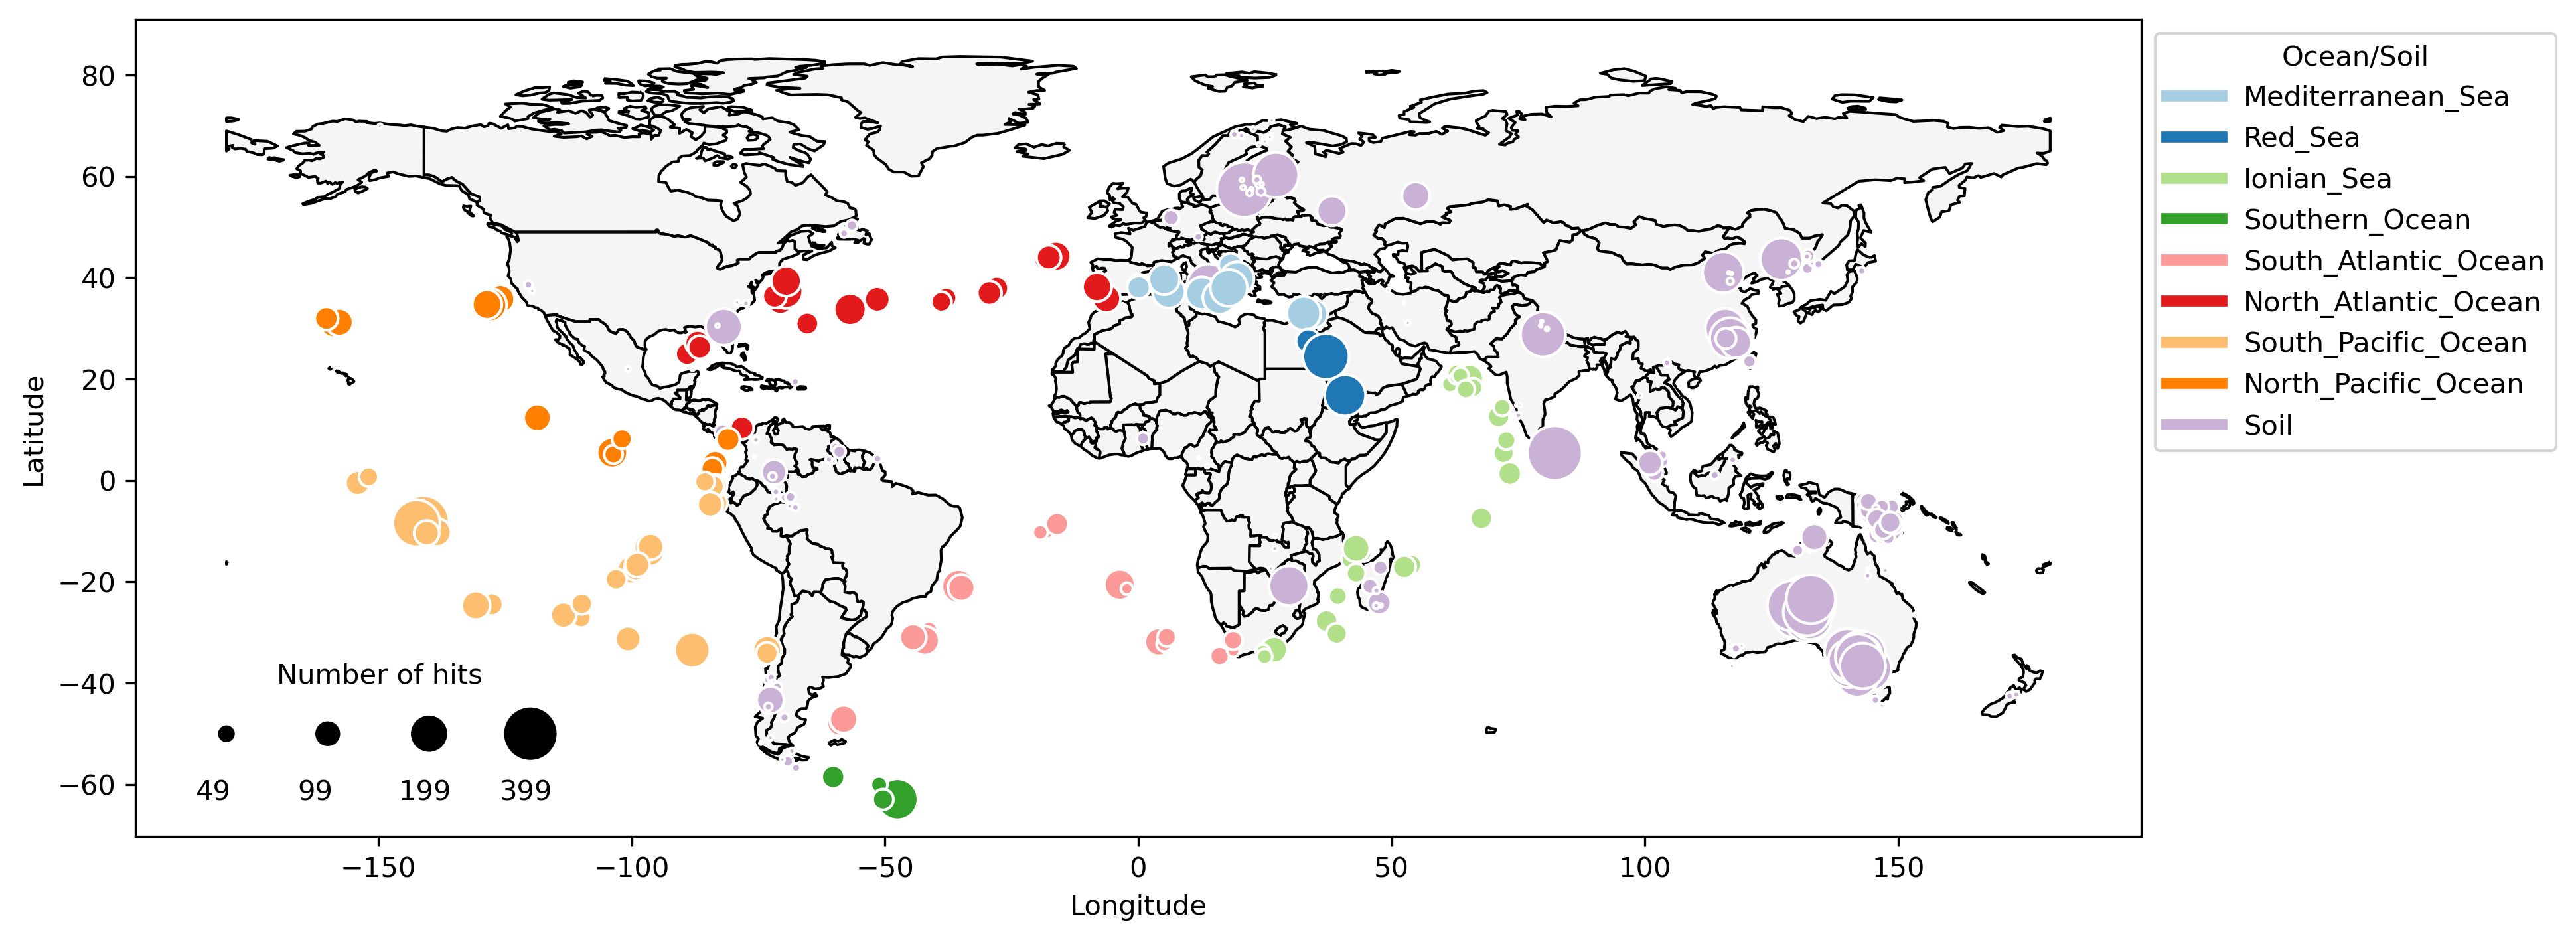

In [20]:
#https://geopandas.org/mapping.html
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
random.seed(1234)
mpl.rcParams['figure.dpi'] = 300
tmp_order = ocean_order.copy()
tmp_order.extend(['Soil'])
oceans = df_ocean.long.tolist()
oceans.extend(['Soil'])

# make geodf
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

tmp = (dfs
           .groupby(col)
           .target_name
           .count()
           .rename('total_count')
           .reset_index()
           .merge((dfs[[col,'ocean','longitude','latitude']]
                    .drop_duplicates()
                    ),on=col,how='left')
          )
print(tmp.shape)
geometry = [Point((xy[0]+random.uniform(-2, 2),xy[1]+random.uniform(-2, 2))) for xy in zip(tmp['longitude'],
                                     tmp['latitude'])]
geo_df = gpd.GeoDataFrame(tmp[['total_count','ocean']],
                          geometry=geometry)

# fix vals for plot
geo_df['total_count'] = geo_df['total_count']
# map color to grouping var
pal = sns.color_palette("Paired",9)
dic2 = dict(zip(tmp_order, pal))
geo_df['ocean_color'] = geo_df.ocean.map(dic2) 

# plot
fig,ax = plt.subplots(figsize=(13,13))
world.plot(ax=ax,color='whitesmoke', edgecolor='k')
geo_df.plot(ax=ax,marker='o',
            c=geo_df.ocean_color,
            markersize='total_count',
            edgecolor='w')

custom_lines = [Line2D([0],[0],color=pal[x],lw=4) for x in range(len(tmp_order))]
plt.legend(custom_lines, oceans,
          bbox_to_anchor=(1,1),
          title='Ocean/Soil')

siz = [geo_df['total_count'].max()/8,
       geo_df['total_count'].max()/4,
       geo_df['total_count'].max()/2,
       geo_df['total_count'].max()/1]
tmp = pd.DataFrame([[0,1],[10,1],[20,1],[30,1]],columns=['x','y'])
tmp['siz'] = siz
tmp = tmp.astype('float')
points = ((-180,-50),(-160,-50),(-140,-50),(-120,-50))
geometry = [Point(xy) for xy in points]
geo_circles = gpd.GeoDataFrame(tmp,
                          geometry=geometry)
geo_circles.plot(ax=ax,marker='o',
            c='k',
            markersize='siz',
            edgecolor='w')
for i in range(len(siz)):
    plt.annotate(str(int(siz[i])),(int(points[i][0]-6),int(points[i][1]-13)))

plt.annotate('Number of hits',(-170,-40))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

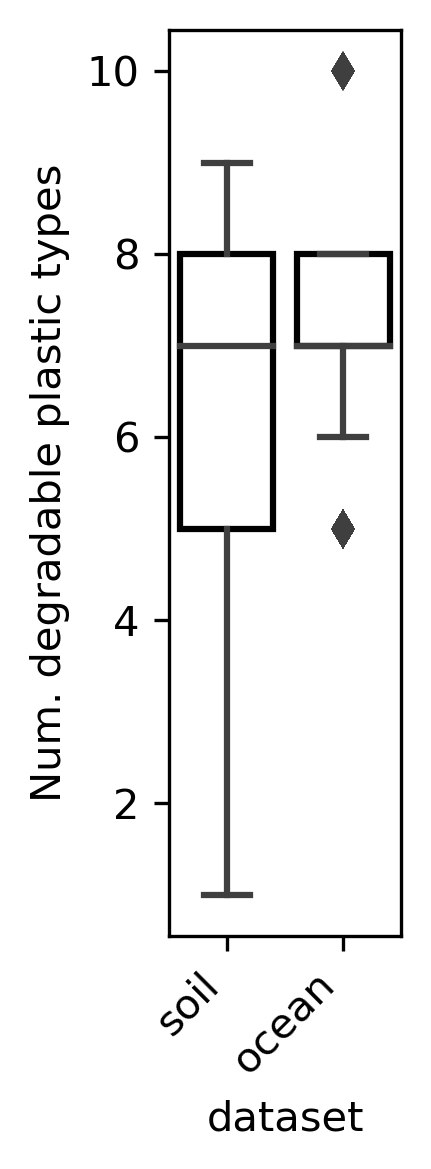

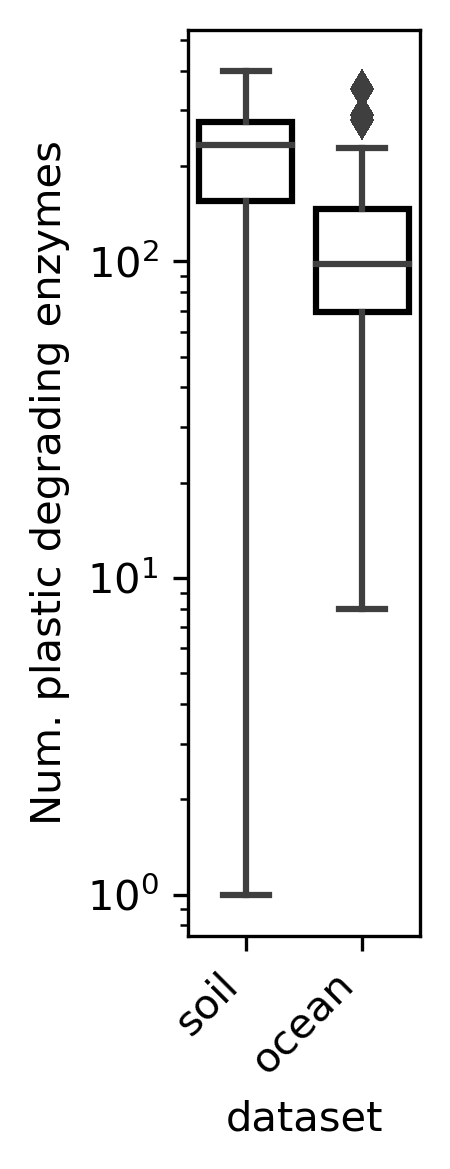

         value
dataset       
ocean        7
soil         7


In [21]:
# Stats analysis per ocean region / soil habitat
# boxplots
tmp = []

tmp.append(dfs
 .replace({'dataset':dic})[[col,'dataset']]
 .drop_duplicates()
.merge((dfs.replace({'dataset':dic})
                 .groupby('dataset')[col]
                 .nunique()
                 .rename('value')
                  .reset_index()),
               on='dataset',how='left')
.drop(columns=['dataset'])
)
tmp[-1]['ylabel'] = 'Num. samples'
tmp.append(dfs.groupby(col).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs.groupby(col).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs.groupby(col).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# separate small plots
for col2 in ["Num. plast.","Num. hits"]:
    plt.figure(figsize=(1,4))
    ax=sns.boxplot(data=pd.concat(tmp)
                .merge(dfs.replace({'dataset':dic})[[col,'dataset']],
                         on=col,how='left')
                .query('ylabel==@col2'),
               y='value',x='dataset',#color='w'
               )
    plt.ylabel(col2)
    if col2 == 'Num. hits':
        plt.yscale('log')
        plt.ylabel(label_hits)
    else:
        plt.ylabel(label_plast)
        
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
    plt.xticks(rotation=45,ha='right')
    plt.show()
    
print(pd.concat(tmp)
                .merge(dfs.replace({'dataset':dic})[[col,'dataset']],
                         on=col,how='left')
                .query('ylabel=="Num. plast."')
      .groupby('dataset')
        .median()
        )

In [22]:
# values text
print(dfs.hmm_model.nunique())
# per ocean/soil hmm models
print(dfs.replace({'dataset':dic}).groupby('dataset').hmm_model.nunique())
# per ocean/soil num hits
print(dfs.replace({'dataset':dic}).groupby('dataset').target_name.count())
print(dfs.replace({'dataset':dic}).groupby('dataset').target_name.count()
      .divide(dfs.replace({'dataset':dic}).groupby('dataset').target_name.count().sum())
     )

# alltogether non-aditives/additives hmm models
print(dfs.groupby('additive').hmm_model.nunique())
# alltogether non-aditives/additives num_hits
print(dfs.groupby('additive').target_name.count())
print(dfs.groupby('additive').target_name.count()
      .divide(dfs.groupby('additive').target_name.count().sum())
     )

# ocean/soil additive/non-additive split
print(dfs.replace({'dataset':dic}).groupby(['dataset','additive']).hmm_model.nunique())
print(dfs
      .replace({'dataset':dic})
      .groupby(['dataset','additive'])
      .target_name
      .count()
      .divide(dfs.replace({'dataset':dic}).groupby('dataset').target_name.count()))

121
dataset
ocean     99
soil     105
Name: hmm_model, dtype: int64
dataset
ocean    11906
soil     18119
Name: target_name, dtype: int64
dataset
ocean    0.396536
soil     0.603464
Name: target_name, dtype: float64
additive
False    38
True     83
Name: hmm_model, dtype: int64
additive
False    12827
True     17198
Name: target_name, dtype: int64
additive
False    0.427211
True     0.572789
Name: target_name, dtype: float64
dataset  additive
ocean    False       32
         True        67
soil     False       32
         True        73
Name: hmm_model, dtype: int64
dataset  additive
ocean    False       0.607425
         True        0.392575
soil     False       0.308792
         True        0.691208
Name: target_name, dtype: float64


In [23]:
# values for text
# diff medians
col2 = 'Num. hits'
tmp2 = (pd.concat(tmp)
                .merge(dfs.replace({'dataset':dic})[[col,'dataset']],
                         on=col,how='left')
                .query('ylabel==@col2')
 .groupby('dataset')
 .value.median()
)
print(tmp2)
print(tmp2.iloc[1]/tmp2.iloc[0])
tmp2 = (pd.concat(tmp)
                .merge(dfs.replace({'dataset':dic})[[col,'dataset']],
                         on=col,how='left')
                .query('ylabel==@col2')
 .groupby('dataset')
 .value.var()
)
print(tmp2.iloc[1]/tmp2.iloc[0])

col2 = 'Num. plast.'
tmp2 = (pd.concat(tmp)
                .merge(dfs.replace({'dataset':dic})[[col,'dataset']],
                         on=col,how='left')
                .query('ylabel==@col2')
 .groupby('dataset')
 .value.median()
)
print(tmp2.iloc[1]/tmp2.iloc[0])
tmp2 = (pd.concat(tmp)
                .merge(dfs.replace({'dataset':dic})[[col,'dataset']],
                         on=col,how='left')
                .query('ylabel==@col2')
 .groupby('dataset')
 .value.var()
)
print(tmp2.iloc[1]/tmp2.iloc[0])
        

dataset
ocean     98
soil     234
Name: value, dtype: int64
2.3877551020408165
1.998070417313284
1.0
4.591840234549316


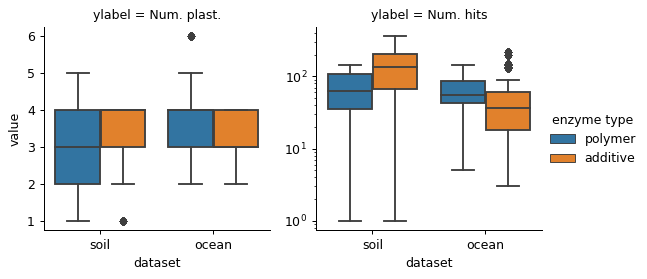

In [24]:
# additives / non-additives

col=['group_id','additive']
tmp = []

tmp.append(dfs.groupby(col).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs.groupby(col).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs.groupby(col).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

mpl.rcParams['figure.dpi'] = 90
g = sns.catplot(data=pd.concat(tmp)
            .merge(dfs.replace({'dataset':dic})[[col[0],'dataset']],
                     on=col[0],how='left')
            .query('ylabel.isin(["Num. samples","Num. plast.","Num. hits"])')
            .replace({'additive':legendmap})
                ,
            col='ylabel',y='value',x='dataset',hue='additive',
            kind='box',sharey=False,height=3,
            legend_out = True
            )
g.axes[0,1].set_yscale('log')
g._legend.set_title(legendtit)
plt.show()

In [25]:
# similar amount of plastic polymer hits in both?

data=(pd.concat(tmp)
            .merge(dfs.replace({'dataset':dic})[[col[0],'dataset']],
                     on=col[0],how='left')
            .query('ylabel.isin(["Num. hits"])')
        .groupby(['dataset','additive']).value.median()
     )
print(data)
print(data.reset_index().query('additive==False').query('dataset=="soil"').value.values[0]/
      data.reset_index().query('additive==False').query('dataset=="ocean"').value.values[0]) # false/false
print(data.reset_index().query('additive==True').query('dataset=="soil"').value.values[0]/
      data.reset_index().query('additive==True').query('dataset=="ocean"').value.values[0]) # true/true

# overrepresentation
# enrichment soil additive
data = data.unstack().transpose()
print(data) 
stats.fisher_exact([data.iloc[0].values,data.iloc[1].values], alternative='greater')


dataset  additive
ocean    False        55
         True         37
soil     False        63
         True        136
Name: value, dtype: int64
1.1454545454545455
3.675675675675676
dataset   ocean  soil
additive             
False        55    63
True         37   136


(3.208923208923209, 5.415399396648405e-06)

## Eggnog analysis

In [26]:
files = ['../data/tar1.fa.eggnog.emapper.annotations',
         '../data/tar2.fa.eggnog.emapper.annotations',
         '../data/soil.fa.eggnog.emapper.annotations']

df_egg = []
for f in files:
    df_egg.append(pd.read_csv(f,sep='\t',skiprows=3,skipfooter=3))
    if 'tar' in f:
        df_egg[-1]['dataset'] = 'ocean'
    else:
        df_egg[-1]['dataset'] = 'soil'
df_egg = pd.concat(df_egg).reset_index(drop=True)
df_egg = df_egg.merge(dfs.drop(columns=['dataset']),
                      left_on='#query_name', right_on='target_name',
                       how='inner')
print(df_egg.shape)
print(df_egg.columns)
df_egg.head()

(29833, 59)
Index(['#query_name', 'seed_eggNOG_ortholog', 'seed_ortholog_evalue',
       'seed_ortholog_score', 'best_tax_level', 'Preferred_name', 'GOs', 'EC',
       'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
       'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction',
       'taxonomic scope', 'eggNOG OGs', 'best eggNOG OG',
       'COG Functional cat.', 'eggNOG free text desc.', 'dataset', 'additive',
       'auc', 'auc_cut', 'bias', 'bias_1d', 'bit_cut', 'country', 'cut_points',
       'depth_id', 'e_value', 'e-value_1d', 'environment', 'group_id',
       'hmm_model', 'id', 'id_other', 'inscd_id', 'latitude', 'longitude',
       'ocean', 'plastic', 'prc_run', 'prec', 'prec_cut', 'query_id',
       'query_name', 'run', 'sample_id', 'score', 'score_1d', 'seqid',
       'size_id', 'target_name', 'tmax', 'tmean', 'tmin'],
      dtype='object')


,#query_name,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,best_tax_level,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,...,run,sample_id,score,score_1d,seqid,size_id,target_name,tmax,tmean,tmin
0,ENA|CEVX01000410|CEVX01000410.1-Marine-metagen...,378806.STAUR_2894,9.200000e-98,364.0,Myxococcales,MA20_17095,NaN,NaN,NaN,NaN,...,ERR599078,CEVX01,340.1,339.8,60,0.22-3,ENA|CEVX01000410|CEVX01000410.1-Marine-metagen...,NaN,NaN,NaN
1,ENA|CEVX01000640|CEVX01000640.1-Marine-metagen...,1366046.HIMB11_01029,9.100000e-231,806.2,unclassified Rhodobacteraceae,alkJ2,NaN,1.1.99.1,ko:K00108,"ko00260,ko01100,map00260,map01100",...,ERR599078,CEVX01,431.2,431.0,95,0.22-3,ENA|CEVX01000640|CEVX01000640.1-Marine-metagen...,NaN,NaN,NaN
2,ENA|CEVX01001735|CEVX01001735.1-Marine-metagen...,1049564.TevJSym_bf00250,3.600000e-58,233.0,unclassified Gammaproteobacteria,NaN,"GO:0005575,GO:0005576",NaN,"ko:K03932,ko:K13277","ko02024,map02024",...,ERR599078,CEVX01,137.1,64.1,65,0.22-3,ENA|CEVX01001735|CEVX01001735.1-Marine-metagen...,NaN,NaN,NaN
3,ENA|CEVX01004819|CEVX01004819.1-Marine-metagen...,413404.Rmag_0764,1.100000e-123,449.9,unclassified Gammaproteobacteria,ascD,"GO:0003674,GO:0003824,GO:0008150,GO:0008152,GO...","1.17.1.1,1.18.1.3","ko:K00523,ko:K00529,ko:K02823,ko:K18077","ko00071,ko00240,ko00360,ko00520,ko00624,ko0110...",...,ERR599078,CEVX01,175.8,175.5,95,0.22-3,ENA|CEVX01004819|CEVX01004819.1-Marine-metagen...,NaN,NaN,NaN
4,ENA|CEVX01006106|CEVX01006106.1-Marine-metagen...,1400524.KL370779_gene793,4.800000e-90,337.0,unclassified Alphaproteobacteria,pobA,NaN,"1.14.13.229,1.14.19.48",ko:K21323,NaN,...,ERR599078,CEVX01,127.2,127.0,95,0.22-3,ENA|CEVX01006106|CEVX01006106.1-Marine-metagen...,NaN,NaN,NaN


## EC analysis

Index(['EC', 'dataset', 'target_name', 'additive', 'ec_l4', 'EC Number',
       'ec_l4_description'],
      dtype='object')


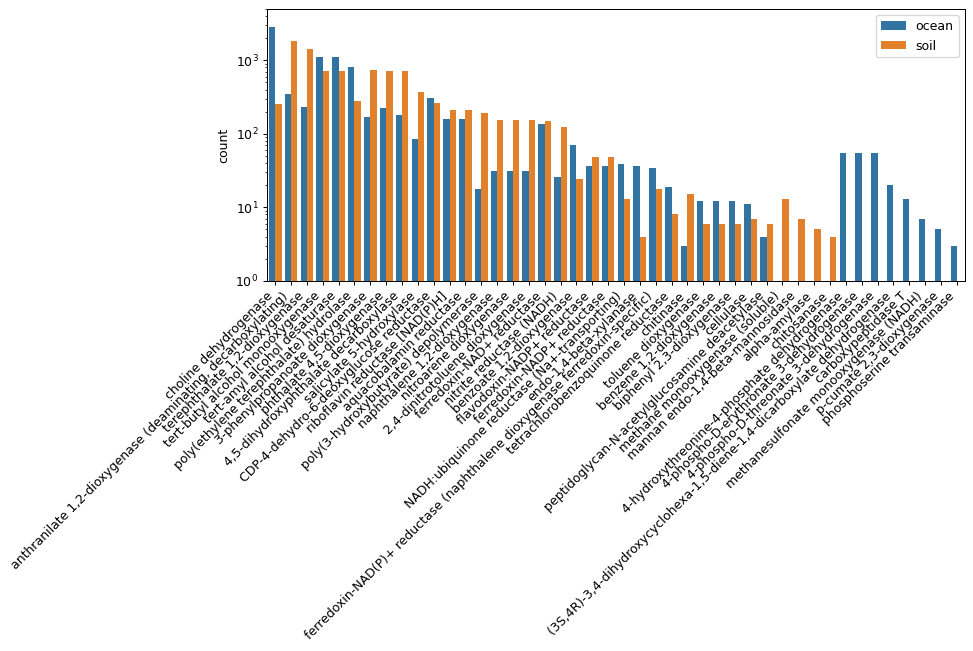

(63,)


In [27]:
# l4
# prepare df for merging
tmp = df_egg.dropna(subset=['EC'])
tmp['ec_l4'] = (df_egg
 .dropna(subset=['EC'])
 .EC
 .apply(lambda x: frozenset(['.'.join(xx.split('.')) for xx in x.split(',')]))
)
tmp = (dframe_stack_list(tmp[['ec_l4','EC','dataset','target_name','additive']],
                  'ec_l4',typ='str')
            .merge(pd.read_excel('../data/enzyme_classifications.xlsx',
              sheet_name='Brenda_EC')
                   .drop(columns='History')
                   .rename(columns={'Recommended Name':'ec_l4_description'}),
             left_on='ec_l4',right_on='EC Number',
                      how='left')
         )
tmp
print(tmp.columns)

plt.figure(figsize=(10,4))
data = (tmp
        .groupby(['dataset','ec_l4_description'])
        .target_name.count()
        .rename('count')
        .sort_values(ascending=False)
        .reset_index()
        .query('count>=3')
       )
# add if in both or single datasets for sorting
data = data.merge(data
                  .groupby('ec_l4_description')['count']
                  .apply(lambda x: len(list(x)))
                  .rename('num_sets')
                  .reset_index(),
                  on='ec_l4_description',how='left')
#sorted dframe
data = (data
        .query('num_sets==2')
        .append(data.query('num_sets==1')
                .sort_values('dataset',ascending=False))
       )

sns.barplot(data=data,
           x='ec_l4_description',y='count',
           hue='dataset') #,join=False)
plt.xticks(rotation=45,ha='right')
plt.yscale('log')
plt.legend(loc=1)
plt.xlabel('')
plt.ylim([1,5000])
plt.show() 
print(tmp.ec_l4.unique().shape)


In [28]:
# for text - num functions, overlap
print(data.groupby('dataset').ec_l4_description.nunique())
tmp2 = data.groupby('dataset').ec_l4_description.unique()
len(set(tmp2.iloc[0]).intersection(set(tmp2.iloc[1])))/data.ec_l4_description.unique().shape[0]

dataset
ocean    40
soil     36
Name: ec_l4_description, dtype: int64


0.7272727272727273

In [29]:
# additive vs non-additive
data = (tmp
        .groupby(['additive','dataset','ec_l4_description'])
        .target_name.count()
        .rename('count')
        .reset_index()
        .query('count>=3')
       )

print(data.groupby(['additive'])
      .ec_l4_description
      .nunique())
tmp2 = data.groupby(['additive']).ec_l4_description.unique()
print(len(set(tmp2.iloc[0]).intersection(set(tmp2.iloc[1])))) #/data.ec_l4_description.unique().shape[0]
len(set(tmp2.iloc[0]).intersection(set(tmp2.iloc[1])))/data.ec_l4_description.unique().shape[0]

additive
False    12
True     33
Name: ec_l4_description, dtype: int64
1


0.022727272727272728

In [30]:
# EC analysis level 3
# merge from l1 down to l3
ec = pd.read_csv('../data/enzyme_ec',sep='\t',names=['tmp'])
# 3rd level
ec['l3'] = (ec['tmp']
              .apply(lambda x: x.split('.- ')[0])
              .apply(lambda x: '.'.join(x.split('.')[:3]).replace(' ',''))
             )
ec['l2'] = (ec['tmp']
              .apply(lambda x: x.split('.- ')[0])
              .apply(lambda x: '.'.join(x.split('.')[:2]).replace(' ',''))
             )
ec['l1'] = (ec['tmp']
              .apply(lambda x: x.split('.- ')[0])
              .apply(lambda x: '.'.join(x.split('.')[:1]).replace(' ',''))
             )
ec['name'] = (ec['tmp']
              .apply(lambda x: x.split('.- ')[1])
             )
ec['l1_description'] = ec.l1.map(ec.groupby('l1').name.first())
ec['l2_description'] = ec.l2.map(ec.query('l3.str.contains("-")').query('~l2.str.contains("-")').set_index('l2').name)
ec = ec.query('~l3.str.contains("-")').rename(columns={'name':'l3_description'})
ec['description'] = ec.l1_description+ec.l2_description+ec.l3_description
ec

,tmp,l3,l2,l1,l3_description,l1_description,l2_description,description
2,1. 1. 1.- With NAD(+) or NADP(+) as acceptor.,1.1.1,1.1,1,With NAD(+) or NADP(+) as acceptor.,Oxidoreductases.,Acting on the CH-OH group of donors.,Oxidoreductases. Acting on the CH-OH group o...
3,1. 1. 2.- With a cytochrome as acceptor.,1.1.2,1.1,1,With a cytochrome as acceptor.,Oxidoreductases.,Acting on the CH-OH group of donors.,Oxidoreductases. Acting on the CH-OH group o...
4,1. 1. 3.- With oxygen as acceptor.,1.1.3,1.1,1,With oxygen as acceptor.,Oxidoreductases.,Acting on the CH-OH group of donors.,Oxidoreductases. Acting on the CH-OH group o...
5,1. 1. 4.- With a disulfide as acceptor.,1.1.4,1.1,1,With a disulfide as acceptor.,Oxidoreductases.,Acting on the CH-OH group of donors.,Oxidoreductases. Acting on the CH-OH group o...
6,1. 1. 5.- With a quinone or similar compoun...,1.1.5,1.1,1,With a quinone or similar compound as accep...,Oxidoreductases.,Acting on the CH-OH group of donors.,Oxidoreductases. Acting on the CH-OH group o...
...,...,...,...,...,...,...,...,...
389,7. 2. 4.- Linked to decarboxylation.,7.2.4,7.2,7,Linked to decarboxylation.,Translocases.,Catalysing the translocation of inorganic ca...,Translocases. Catalysing the translocation o...
391,7. 3. 2.- Linked to the hydrolysis of a nuc...,7.3.2,7.3,7,Linked to the hydrolysis of a nucleoside tr...,Translocases.,Catalysing the translocation of inorganic an...,Translocases. Catalysing the translocation o...
393,7. 4. 2.- Linked to the hydrolysis of a nuc...,7.4.2,7.4,7,Linked to the hydrolysis of a nucleoside tr...,Translocases.,Catalysing the translocation amino acids and...,Translocases. Catalysing the translocation a...
395,7. 5. 2.- Linked to the hydrolysis of a nuc...,7.5.2,7.5,7,Linked to the hydrolysis of a nucleoside tr...,Translocases.,Catalysing the translocation carbohydrates a...,Translocases. Catalysing the translocation c...


<Figure size 600x300 with 0 Axes>

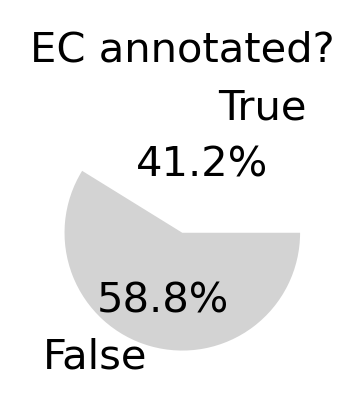

In [31]:
# pie how many ec annotated in eggnog
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,1))
(pd.DataFrame([[True,df_egg.EC.dropna().shape[0]],
             [False,df_egg.EC.isna().sum()]],columns=['name',''])
 .set_index('name')
 .plot.pie(subplots=True,
           figsize=(1.3,1.3),
          legend=False,
          autopct='%1.1f%%',
          colors=['w','lightgrey']
          )
)
plt.title('EC annotated?',fontsize=10)
plt.show()

### partition by additives both L1 and L4

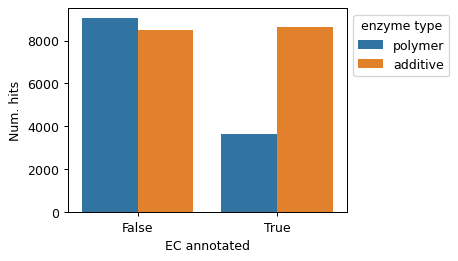

2.358939311098961
0.2879634731953082


In [32]:
df_egg['ec_true'] = df_egg.EC.isna().apply(lambda x: not(x))
df_egg.groupby(['ec_true','additive']).target_name.count()

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
sns.barplot(data=df_egg
            .groupby(['ec_true','additive'])
            .target_name.count()
            .reset_index()
            .replace({'additive':legendmap}),
            x='ec_true',y='target_name',
            hue='additive')
plt.legend(title=legendtit,
           bbox_to_anchor=(1,1))
plt.ylabel('Num. hits')
plt.xlabel('EC annotated')
plt.show()

#values
data = (df_egg
            .groupby(['ec_true','additive'])
            .target_name.count()
            .reset_index()
       )
print(data.query('ec_true==True').query('additive==True').target_name.values[0]/
      data.query('ec_true==True').query('additive==False').target_name.values[0])

print(data.query('ec_true==True').query('additive==False').target_name.values[0]/
      (data.query('ec_true==True').query('additive==False').target_name.values[0]+
      data.query('ec_true==False').query('additive==False').target_name.values[0])
      )

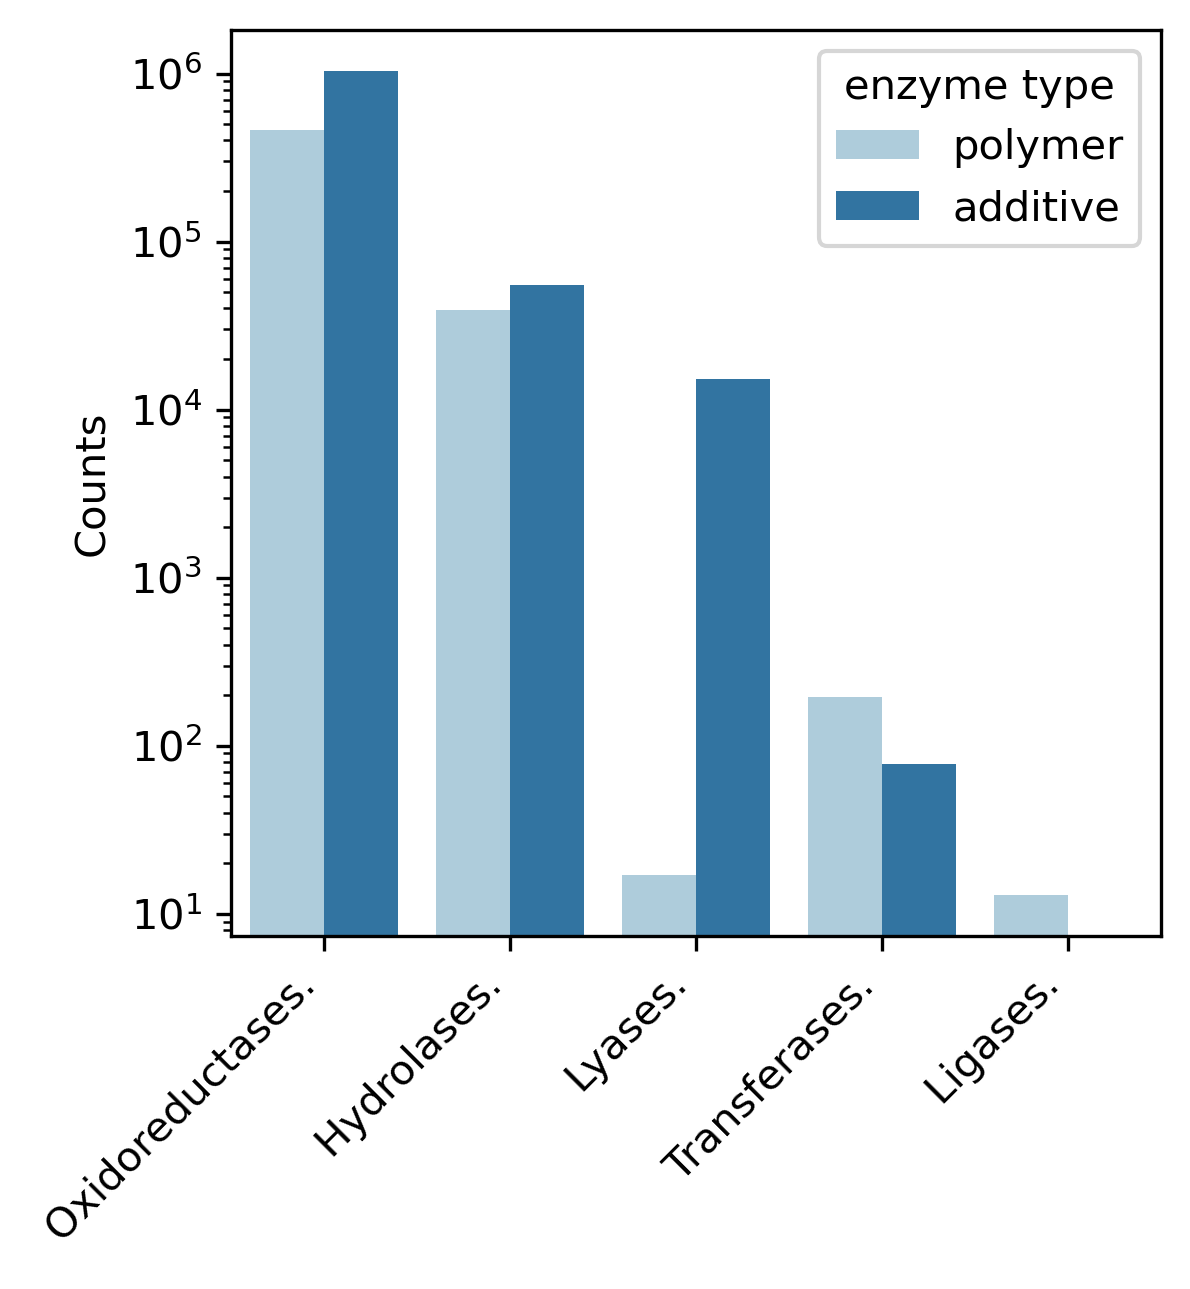

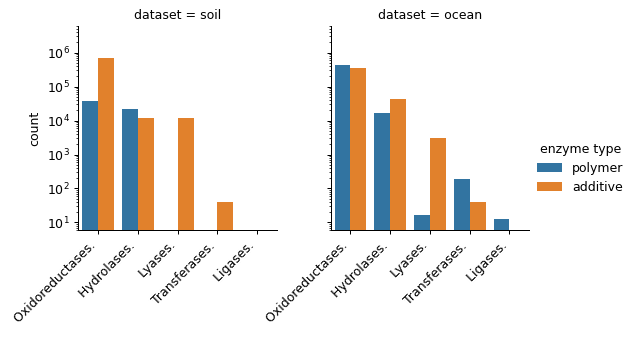

In [33]:
tmp = df_egg.dropna(subset=['EC'])
tmp['ec_l1'] = (df_egg
 .dropna(subset=['EC'])
 .EC
 .apply(lambda x: frozenset(['.'.join(xx.split('.')[:1]) for xx in x.split(',')]))
)
tmp = (dframe_stack_list(tmp[['ec_l1','EC','dataset','target_name']],'ec_l1',typ='str')
       .merge(ec[['l1','l1_description']],
              left_on='ec_l1',right_on='l1',how='left')
       .merge(dfs[['target_name','additive']],
         on='target_name',how='left')
      )

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,4))
data = (tmp
        .groupby(['additive','l1_description'])
        .target_name
        .count()
        .rename('count')
        .reset_index()
        .query('count>10')
        .sort_values(by='count',ascending=False)
        .replace({'additive':legendmap})
       )
sns.barplot(data=data,
           x='l1_description',y='count',
           hue='additive',palette=palett,
           hue_order=legendmap.values()
           )
plt.xticks(rotation=45,ha='right')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Counts')
plt.legend(title=legendtit,loc=1)
plt.show()

# per dataset - so catplot
mpl.rcParams['figure.dpi'] = 90
data = (tmp
        .groupby(['dataset','additive','l1_description'])
        .target_name
        .count()
        .rename('count')
        .reset_index()
        .query('count>10')
        .sort_values(by='count',ascending=False)
        .replace({'additive':legendmap})
       )
g = sns.catplot(data=data,kind='bar',
           x='l1_description',y='count',
           hue='additive',col='dataset',
           #sharey=False,
           hue_order=legendmap.values(),
           height=3,legend_out = True)
for ax in g.axes[0]:
    ax.set_xticklabels(ax.get_xticklabels(),
                          rotation=45,ha='right')
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylim([6,6e6])
g._legend.set_title(legendtit)
plt.show()

Index(['EC', 'dataset', 'target_name', 'additive', 'ec_l4', 'EC Number',
       'ec_l4_description'],
      dtype='object')


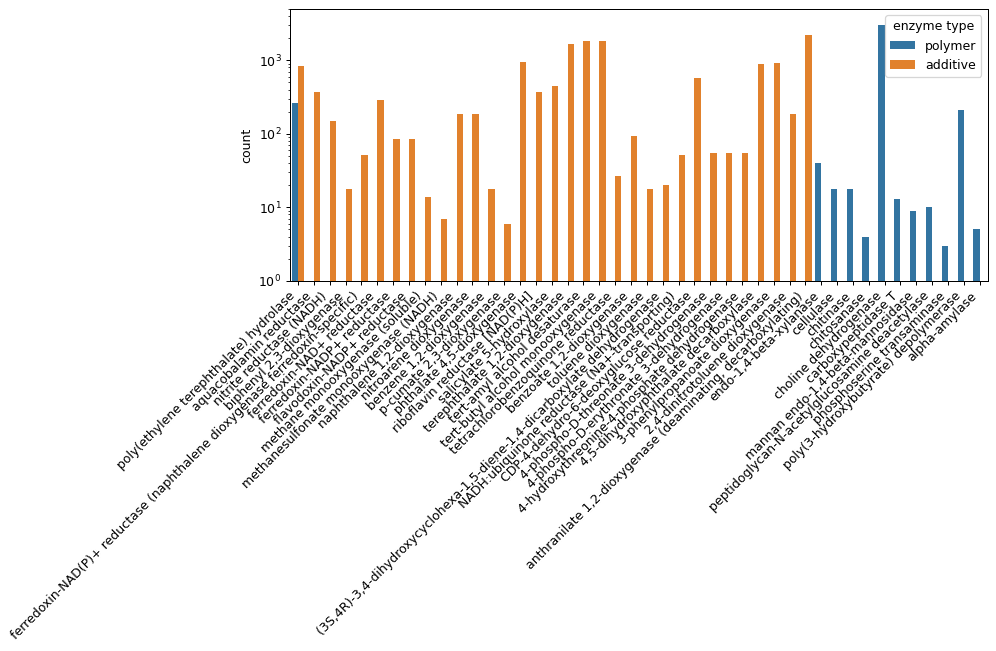

(63,)


In [34]:
# l4
# prepare df for merging
tmp = df_egg.dropna(subset=['EC'])
tmp['ec_l4'] = (df_egg
 .dropna(subset=['EC'])
 .EC
 .apply(lambda x: frozenset(['.'.join(xx.split('.')) for xx in x.split(',')]))
)
tmp = (dframe_stack_list(tmp[['ec_l4','EC','dataset','target_name','additive']],
                  'ec_l4',typ='str')
            .merge(pd.read_excel('../data/enzyme_classifications.xlsx',
              sheet_name='Brenda_EC')
                   .drop(columns='History')
                   .rename(columns={'Recommended Name':'ec_l4_description'}),
             left_on='ec_l4',right_on='EC Number',
                      how='left')
         )
tmp
print(tmp.columns)

plt.figure(figsize=(10,4))
data = (tmp
        .groupby(['additive','ec_l4_description'])
        .target_name.count()
        .rename('count')
        .reset_index()
        .query('count>=3')
       )
# add if in both or single datasets for sorting
data = data.merge(data
                  .groupby('ec_l4_description')['count']
                  .apply(lambda x: len(list(x)))
                  .rename('num_sets')
                  .reset_index(),
                  on='ec_l4_description',how='left')
#sorted dframe
data = (data
        .query('num_sets==2')
        .append(data.query('num_sets==1')
                .sort_values('additive',ascending=False))
        .replace({'additive':legendmap})
       )

sns.barplot(data=data,
           x='ec_l4_description',y='count',
           hue='additive') #,join=False)
plt.xticks(rotation=45,ha='right')
plt.yscale('log')
plt.legend(title=legendtit,loc=1)
plt.xlabel('')
plt.ylim([1,5000])
plt.show() 
print(tmp.ec_l4.unique().shape)

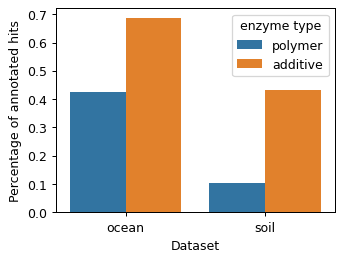

In [35]:
# check ocean vs soil additive vs non-additive

data = (df_egg.query('ec_true==True')
            .groupby(['dataset','additive'])
            .target_name.count()
 .divide((dfs.replace({'dataset':dic})
 .groupby(['dataset','additive'])
 .target_name.count()
))
 .reset_index()
 .replace({'additive':legendmap})
)
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
sns.barplot(data=data,
            x='dataset',y='target_name',
            hue='additive')
plt.legend(title=legendtit,
           bbox_to_anchor=(1,1))
plt.ylabel('Percentage of annotated hits')
plt.xlabel('Dataset')
plt.show()

In [36]:
# and how much in the ocean vs the soil
data=(df_egg.query('ec_true==True')
            .groupby(['dataset'])
            .target_name.count()
 .divide((dfs.replace({'dataset':dic})
 .groupby(['dataset'])
 .target_name.count()
))
 #.reset_index()
)
print(data.iloc[1]/data.iloc[0])
data

0.6289448218171675


dataset
ocean    0.527297
soil     0.331641
Name: target_name, dtype: float64